In [ ]:
'''
#connect to google
from google.colab import drive
drive.mount('/content/drive')
'''

"\n#connect to google\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [ ]:
'''
cd '/content/drive/My Drive/Colab Notebooks/Group 1'
'''

"\ncd '/content/drive/My Drive/Colab Notebooks/Group 1'\n"

# 1. Data loading and overview

In [ ]:
# Load packages
import pandas as pd 
import numpy as np

In [ ]:
# Loading data
train = pd.read_csv('train.csv')
train.head()

,rating,reviewText,summary
0,3,Plot Storyline: 5 StarsThis novel accomplished...,3 1/4 Stars
1,3,I did not like how EL ended this one. I don't ...,"It was going great, then just.... ended"
2,5,I love how old fashioned this family is - they...,LOVED ALL 4!
3,5,I loved this story - It's about two friends wh...,friends make the best lovers
4,1,"In the Dark Lands, a virus killed all possibil...",Blatantly sexist and homophobic


In [ ]:
train['text']=train['summary'] + " " + train['reviewText']

In [ ]:
train['rating']=train['rating']-1

In [ ]:
train.head()

,rating,reviewText,summary,text
0,2,Plot Storyline: 5 StarsThis novel accomplished...,3 1/4 Stars,3 1/4 Stars Plot Storyline: 5 StarsThis novel ...
1,2,I did not like how EL ended this one. I don't ...,"It was going great, then just.... ended","It was going great, then just.... ended I did ..."
2,4,I love how old fashioned this family is - they...,LOVED ALL 4!,LOVED ALL 4! I love how old fashioned this fam...
3,4,I loved this story - It's about two friends wh...,friends make the best lovers,friends make the best lovers I loved this stor...
4,0,"In the Dark Lands, a virus killed all possibil...",Blatantly sexist and homophobic,Blatantly sexist and homophobic In the Dark La...


In [ ]:
#split our train into training, validation, test

#seed( ) Integer value used to specify the start of the algorithm to use when generating random numbers.
np.random.seed(0)
#split our data into training and test data with the proportion of 80/20
a_train,df_test=np.split(train.sample(frac=1,random_state=42),[int(.8*len(train))])
#split the training  into train and validation  with the proportion of 80/20
df_train,df_val=np.split(a_train.sample(frac=1,random_state=42),[int(.8*len(a_train))])
print(len(df_train),len(df_val), len(df_test))

5760 1440 1800


In [ ]:
# Change pandas to numpy
np_val = np.array(df_val['rating'])
np_test = np.array(df_test['rating'])

# 2. Dataset Class

In [ ]:
pip install transformers

In [ ]:
# Import packages
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
# torch.utils.data.Dataset
class Dataset(torch.utils.data.Dataset):

    def __init__(self, train):

        self.labels = train['rating'].tolist()
        # change series to list
        self.texts = [tokenizer(text, padding='max_length', max_length = 512, truncation=True,return_tensors="pt") for text in train['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)
#__len__()：get length

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
#__getitem__()：get items

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

# 3. Model Building

In [ ]:
from torch import nn
from transformers import BertModel


class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        self.bert=BertModel.from_pretrained('bert-base-cased') 
        self.dropout=nn.Dropout(dropout) # avoid overfitting
        self.linear=nn.Linear(768,5) # 768 hidden size, 5 outputs
        self.relu=nn.ReLU()

    def forward(self,input_id,mask):
        
        _,pooled_output=self.bert(input_ids=input_id,attention_mask=mask,return_dict=False)        
        dropput_output=self.dropout(pooled_output)
        linear_output=self.linear(dropput_output)
        final_layer=self.relu(linear_output)
        #At the end of the linear layer, we have a vector of size 5, each corresponds to a category of our labels
        return final_layer    


       

        

# 4. Training Loop

## 4.1 Define F1-score as a measure

In [ ]:
# https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = preds.flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

## 4.2 Initialize hyperparameters (batch size=2,epochs=10,learning rate=1e-6)

In [ ]:
from torch.optim import Adam
from tqdm import tqdm


def train(model, train_data, val_data, learning_rate, epochs):
    train_loss = []
    val_loss = []
    
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0
              
        for train_input, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
                
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
                
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        
        total_acc_val = 0
        total_loss_val = 0
        val_pred_list = [] 
        
        with torch.no_grad():
   
            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
            
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                    
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
                
                val_pred = output.argmax(dim=1).tolist()
                val_pred_list.append(val_pred)
                
        val_f1 = f1_score_func(np.array(val_pred_list), np_val)
        
        
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .4f} \
            | Train Accuracy: {total_acc_train / len(train_data): .4f} \
            | Val Loss: {total_loss_val / len(val_data): .4f} \
            | Val Accuracy: {total_acc_val / len(val_data): .4f}\
            | Val F1 score: {val_f1: .4f} ')
            
        train_loss.append(total_loss_train / len(train_data))
        val_loss.append(total_loss_val / len(val_data))
    return train_loss, val_loss
                  
EPOCHS = 10
model = BertClassifier()
LR = 1e-6
              
train_loss, val_loss = train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 2880/2880 [06:20<00:00,  7.57it/s]


Epochs: 1 | Train Loss:  0.7794             | Train Accuracy:  0.2818             | Val Loss:  0.6817             | Val Accuracy:  0.4264            | Val F1 score:  0.3837 


100%|██████████| 2880/2880 [06:18<00:00,  7.61it/s]


Epochs: 2 | Train Loss:  0.6075             | Train Accuracy:  0.4934             | Val Loss:  0.5605             | Val Accuracy:  0.5264            | Val F1 score:  0.4860 


100%|██████████| 2880/2880 [06:17<00:00,  7.62it/s]


Epochs: 3 | Train Loss:  0.5061             | Train Accuracy:  0.5788             | Val Loss:  0.5116             | Val Accuracy:  0.5549            | Val F1 score:  0.5421 


100%|██████████| 2880/2880 [06:18<00:00,  7.62it/s]


Epochs: 4 | Train Loss:  0.4366             | Train Accuracy:  0.6389             | Val Loss:  0.5012             | Val Accuracy:  0.5708            | Val F1 score:  0.5595 


100%|██████████| 2880/2880 [06:17<00:00,  7.62it/s]


Epochs: 5 | Train Loss:  0.3737             | Train Accuracy:  0.7155             | Val Loss:  0.5021             | Val Accuracy:  0.5674            | Val F1 score:  0.5658 


100%|██████████| 2880/2880 [06:17<00:00,  7.62it/s]


Epochs: 6 | Train Loss:  0.3106             | Train Accuracy:  0.7873             | Val Loss:  0.5224             | Val Accuracy:  0.5556            | Val F1 score:  0.5518 


100%|██████████| 2880/2880 [06:20<00:00,  7.57it/s]


Epochs: 7 | Train Loss:  0.2400             | Train Accuracy:  0.8540             | Val Loss:  0.5414             | Val Accuracy:  0.5660            | Val F1 score:  0.5682 


100%|██████████| 2880/2880 [06:23<00:00,  7.51it/s]


Epochs: 8 | Train Loss:  0.1789             | Train Accuracy:  0.9082             | Val Loss:  0.5895             | Val Accuracy:  0.5597            | Val F1 score:  0.5551 


100%|██████████| 2880/2880 [06:17<00:00,  7.62it/s]


Epochs: 9 | Train Loss:  0.1245             | Train Accuracy:  0.9483             | Val Loss:  0.6737             | Val Accuracy:  0.5375            | Val F1 score:  0.5388 


100%|██████████| 2880/2880 [06:18<00:00,  7.62it/s]


Epochs: 10 | Train Loss:  0.0868             | Train Accuracy:  0.9677             | Val Loss:  0.6987             | Val Accuracy:  0.5451            | Val F1 score:  0.5470 


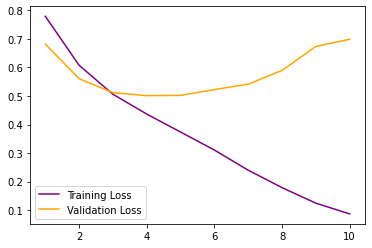

In [ ]:
# Plot training loss and validation loss
import matplotlib.pyplot as plt
plt.figure()
x = np.arange(1, EPOCHS+1)
plt.plot(x, train_loss, label="Training Loss",color="purple")
plt.plot(x, val_loss, label="Validation Loss",color="orange")
plt.legend()
plt.show()

## 4.3 Tuning hyperparameters

###1 (epoch=6,batchsize=2,lr=2e-5)

In [ ]:
from torch.optim import Adam
from tqdm import tqdm


def train(model, train_data, val_data, learning_rate, epochs):
    train_loss = []
    val_loss = []
    
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0
              
        for train_input, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
                
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
                
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        
        total_acc_val = 0
        total_loss_val = 0
        val_pred_list = [] 
        
        with torch.no_grad():
   
            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
            
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                    
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
                
                val_pred = output.argmax(dim=1).tolist()
                val_pred_list.append(val_pred)
                
        val_f1 = f1_score_func(np.array(val_pred_list), np_val)
        
        
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .4f} \
            | Train Accuracy: {total_acc_train / len(train_data): .4f} \
            | Val Loss: {total_loss_val / len(val_data): .4f} \
            | Val Accuracy: {total_acc_val / len(val_data): .4f}\
            | Val F1 score: {val_f1: .4f} ')
            
        train_loss.append(total_loss_train / len(train_data))
        val_loss.append(total_loss_val / len(val_data))
    return train_loss, val_loss
                  
EPOCHS = 6
model = BertClassifier()
LR = 2e-5
              
train_loss, val_loss = train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 2880/2880 [06:17<00:00,  7.62it/s]


Epochs: 1 | Train Loss:  0.6049             | Train Accuracy:  0.4648             | Val Loss:  0.5360             | Val Accuracy:  0.5312            | Val F1 score:  0.5335 


100%|██████████| 2880/2880 [06:17<00:00,  7.63it/s]


Epochs: 2 | Train Loss:  0.4504             | Train Accuracy:  0.6109             | Val Loss:  0.5269             | Val Accuracy:  0.5146            | Val F1 score:  0.5192 


100%|██████████| 2880/2880 [06:17<00:00,  7.62it/s]


Epochs: 3 | Train Loss:  0.2948             | Train Accuracy:  0.7738             | Val Loss:  0.5460             | Val Accuracy:  0.5806            | Val F1 score:  0.5803 


100%|██████████| 2880/2880 [06:17<00:00,  7.62it/s]


Epochs: 4 | Train Loss:  0.1711             | Train Accuracy:  0.8786             | Val Loss:  0.6780             | Val Accuracy:  0.5757            | Val F1 score:  0.5659 


100%|██████████| 2880/2880 [06:17<00:00,  7.62it/s]


Epochs: 5 | Train Loss:  0.0994             | Train Accuracy:  0.9311             | Val Loss:  0.8566             | Val Accuracy:  0.5465            | Val F1 score:  0.5371 


100%|██████████| 2880/2880 [06:17<00:00,  7.62it/s]


Epochs: 6 | Train Loss:  0.0727             | Train Accuracy:  0.9503             | Val Loss:  0.9131             | Val Accuracy:  0.5646            | Val F1 score:  0.5612 


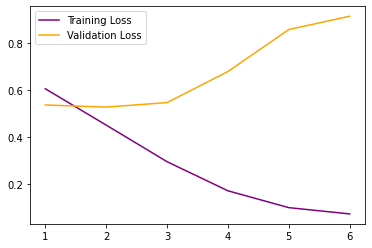

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot training loss and validation loss
import matplotlib.pyplot as plt
plt.figure()
x = np.arange(1, EPOCHS+1)
plt.plot(x, train_loss, label="Training Loss",color="purple")
plt.plot(x, val_loss, label="Validation Loss",color="orange")
plt.legend()
plt.show()
plt.savefig('1')

###2 (epoch=6,batchsize=16,lr=1e-6)

In [ ]:
from torch.optim import Adam
from tqdm import tqdm


def train(model, train_data, val_data, learning_rate, epochs):
    train_loss = []
    val_loss = []
    
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0
              
        for train_input, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
                
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
                
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        
        total_acc_val = 0
        total_loss_val = 0
        val_pred_list = [] 
        
        with torch.no_grad():
   
            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
            
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                    
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
                
                val_pred = output.argmax(dim=1).tolist()
                val_pred_list.append(val_pred)
                
        val_f1 = f1_score_func(np.array(val_pred_list), np_val)
        
        
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .4f} \
            | Train Accuracy: {total_acc_train / len(train_data): .4f} \
            | Val Loss: {total_loss_val / len(val_data): .4f} \
            | Val Accuracy: {total_acc_val / len(val_data): .4f}\
            | Val F1 score: {val_f1: .4f} ')
            
        train_loss.append(total_loss_train / len(train_data))
        val_loss.append(total_loss_val / len(val_data))
    return train_loss, val_loss
                  
EPOCHS = 6
model = BertClassifier()
LR = 1e-6
              
train_loss, val_loss = train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 360/360 [04:44<00:00,  1.27it/s]


Epochs: 1 | Train Loss:  0.1008             | Train Accuracy:  0.2269             | Val Loss:  1.6033             | Val Accuracy:  0.2389            | Val F1 score:  0.2205 


100%|██████████| 360/360 [04:44<00:00,  1.27it/s]


Epochs: 2 | Train Loss:  0.0990             | Train Accuracy:  0.2703             | Val Loss:  1.5550             | Val Accuracy:  0.3014            | Val F1 score:  0.2785 


100%|██████████| 360/360 [04:44<00:00,  1.27it/s]


Epochs: 3 | Train Loss:  0.0903             | Train Accuracy:  0.3559             | Val Loss:  1.3537             | Val Accuracy:  0.4007            | Val F1 score:  0.3716 


100%|██████████| 360/360 [04:44<00:00,  1.27it/s]


Epochs: 4 | Train Loss:  0.0797             | Train Accuracy:  0.4253             | Val Loss:  1.2407             | Val Accuracy:  0.4556            | Val F1 score:  0.4165 


100%|██████████| 360/360 [04:44<00:00,  1.27it/s]


Epochs: 5 | Train Loss:  0.0738             | Train Accuracy:  0.4658             | Val Loss:  1.1754             | Val Accuracy:  0.4813            | Val F1 score:  0.4452 


100%|██████████| 360/360 [04:44<00:00,  1.27it/s]


Epochs: 6 | Train Loss:  0.0696             | Train Accuracy:  0.5135             | Val Loss:  1.1448             | Val Accuracy:  0.5007            | Val F1 score:  0.4660 


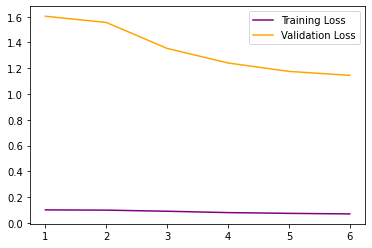

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot training loss and validation loss
import matplotlib.pyplot as plt
plt.figure()
x = np.arange(1, EPOCHS+1)
plt.plot(x, train_loss, label="Training Loss",color="purple")
plt.plot(x, val_loss, label="Validation Loss",color="orange")
plt.legend()
plt.show()
plt.savefig('2')

###3 ADAM--->SGD(epochs=6,batchsize=2,lr=1e-6)

In [ ]:
from torch.optim import SGD
from tqdm import tqdm


def train(model, train_data, val_data, learning_rate, epochs):
    train_loss = []
    val_loss = []
    
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr= learning_rate)

    if use_cuda:

        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0
              
        for train_input, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
                
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
                
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        
        total_acc_val = 0
        total_loss_val = 0
        val_pred_list = [] 
        
        with torch.no_grad():
   
            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
            
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                    
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
                
                val_pred = output.argmax(dim=1).tolist()
                val_pred_list.append(val_pred)
                
        val_f1 = f1_score_func(np.array(val_pred_list), np_val)
        
        
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .4f} \
            | Train Accuracy: {total_acc_train / len(train_data): .4f} \
            | Val Loss: {total_loss_val / len(val_data): .4f} \
            | Val Accuracy: {total_acc_val / len(val_data): .4f}\
            | Val F1 score: {val_f1: .4f} ')
            
        train_loss.append(total_loss_train / len(train_data))
        val_loss.append(total_loss_val / len(val_data))
    return train_loss, val_loss
                  
EPOCHS = 6
model = BertClassifier()
LR = 1e-6
              
train_loss, val_loss = train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 2880/2880 [05:35<00:00,  8.58it/s]


Epochs: 1 | Train Loss:  0.8137             | Train Accuracy:  0.2111             | Val Loss:  0.8199             | Val Accuracy:  0.1958            | Val F1 score:  0.1620 


100%|██████████| 2880/2880 [05:35<00:00,  8.60it/s]


Epochs: 2 | Train Loss:  0.8118             | Train Accuracy:  0.2104             | Val Loss:  0.8114             | Val Accuracy:  0.2132            | Val F1 score:  0.1784 


100%|██████████| 2880/2880 [05:34<00:00,  8.60it/s]


Epochs: 3 | Train Loss:  0.8111             | Train Accuracy:  0.2108             | Val Loss:  0.8077             | Val Accuracy:  0.2056            | Val F1 score:  0.1820 


100%|██████████| 2880/2880 [05:35<00:00,  8.60it/s]


Epochs: 4 | Train Loss:  0.8094             | Train Accuracy:  0.2134             | Val Loss:  0.8140             | Val Accuracy:  0.2007            | Val F1 score:  0.1765 


100%|██████████| 2880/2880 [05:34<00:00,  8.60it/s]


Epochs: 5 | Train Loss:  0.8081             | Train Accuracy:  0.2127             | Val Loss:  0.8046             | Val Accuracy:  0.2299            | Val F1 score:  0.2079 


100%|██████████| 2880/2880 [05:35<00:00,  8.59it/s]


Epochs: 6 | Train Loss:  0.8097             | Train Accuracy:  0.2102             | Val Loss:  0.8111             | Val Accuracy:  0.2118            | Val F1 score:  0.1899 


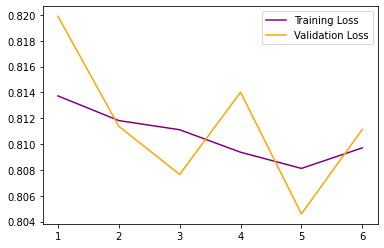

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot training loss and validation loss
import matplotlib.pyplot as plt
plt.figure()
x = np.arange(1, EPOCHS+1)
plt.plot(x, train_loss, label="Training Loss",color="purple")
plt.plot(x, val_loss, label="Validation Loss",color="orange")
plt.legend()
plt.show()
plt.savefig('3')

## 4.4 Final model (Adam,epoch=4,batchsize=2,lr=1e-6)
  using a_train=df_train+df vali

In [ ]:

from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, test_data, learning_rate, epochs):

    train, test = Dataset(train_data), Dataset(test_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_test = 0
            total_loss_test = 0

            with torch.no_grad():
#不更新gradients
                for test_input, test_label in test_dataloader:

                    test_label = test_label.to(device)
                    mask = test_input['attention_mask'].to(device)
                    input_id = test_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, test_label)
                    total_loss_test += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == test_label).sum().item()
                    total_acc_test += acc
            
            print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .4f} \
                | Train Accuracy: {total_acc_train / len(train_data): .4f} \
                | Test Loss: {total_loss_test / len(test_data): .4f} \
                | Test Accuracy: {total_acc_test / len(test_data): .4f}')
EPOCHS = 4
model = BertClassifier()
LR = 1e-6
              
train(model, a_train, df_test, LR, EPOCHS)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3600/3600 [07:53<00:00,  7.60it/s]


Epochs: 1 | Train Loss:  0.7378                 | Train Accuracy:  0.3544                 | Test Loss:  0.6124                 | Test Accuracy:  0.4711


100%|██████████| 3600/3600 [07:52<00:00,  7.62it/s]


Epochs: 2 | Train Loss:  0.5334                 | Train Accuracy:  0.5515                 | Test Loss:  0.5268                 | Test Accuracy:  0.5383


100%|██████████| 3600/3600 [07:52<00:00,  7.62it/s]


Epochs: 3 | Train Loss:  0.4543                 | Train Accuracy:  0.6229                 | Test Loss:  0.5046                 | Test Accuracy:  0.5722


100%|██████████| 3600/3600 [07:52<00:00,  7.62it/s]


Epochs: 4 | Train Loss:  0.3966                 | Train Accuracy:  0.6828                 | Test Loss:  0.4998                 | Test Accuracy:  0.5650


# 5. Model Evaluation
using df_test

In [ ]:

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    test_pred_list = []
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            test_pred = output.argmax(dim=1).tolist()
            test_pred_list.append(test_pred)
                
    test_f1 = f1_score_func(np.array(test_pred_list), np_test)
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .4f} | Test F1 score: {test_f1: .4f}')
    
evaluate(model, df_test)


Test Accuracy:  0.5839 | Test F1 score:  0.5770
